# CNN Mimarisi ile Metin Sınıflandırması Yaparak Metinden Duygu Analizi

* Documentation :  https://metehanozdeniz.com/projects/2024-04-30-text-classification-and-sentiment-analysis-using-cnn/

# import libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import ZeroPadding1D
import pickle

# Read and Preprocessing data

In [49]:
train_df = pd.read_csv("dataset/train.txt", delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("dataset/val.txt", delimiter=';', header=None, names=['sentence','label'])

test_df = pd.read_csv("dataset/test.txt", delimiter=';', header=None, names=['sentence','label'])

In [50]:
train_df.head(10)

,sentence,label
0,aşağılanmış hissetmedim,üzgün
1,Sadece önemseyen ve uyanık birinin yanında old...,üzgün
2,paylaşım yapmak için bir dakika ayırıyorum açg...,öfke
3,Şömineyle ilgili nostaljik hisler yaşıyorum on...,sevgi
4,huysuz hissediyorum,öfke
5,son zamanlarda kendimi biraz yük altında hisse...,üzgün
6,Tavsiye edilen miktarın miligramını veya katın...,şaşkın
7,Hayat konusunda bir ergen kadar kafam karışık ...,korku
8,Yıllardır Petronas'la birlikteyim Petronas'ın ...,mutlu
9,ben de romantik hissediyorum,sevgi


In [51]:
train_df['label'].value_counts() # etiketlerin sayısı

label
mutlu     5361
üzgün     4665
öfke      2160
korku     1937
sevgi     1304
şaşkın     573
Name: count, dtype: int64

In [52]:
train_df['label'].unique() # etiketlerin isimleri benzeyenler var mı diye kontrol

array(['üzgün', 'öfke', 'sevgi', 'şaşkın', 'korku', 'mutlu'], dtype=object)

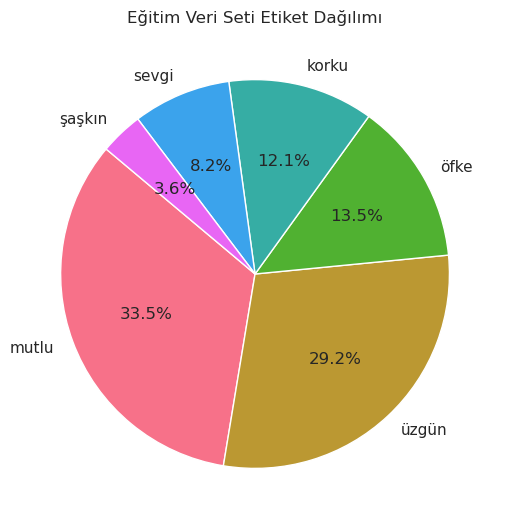

In [53]:
label_counts = train_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts)) # renk paleti olşuturulması
sns.set(style="whitegrid") # arka plan rengi
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors) # pasta grafiği oluşturulması
plt.title('Eğitim Veri Seti Etiket Dağılımı')
plt.show()

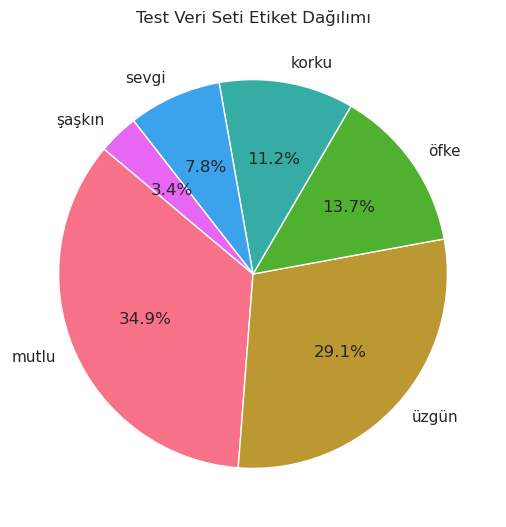

In [54]:
label_counts = test_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts)) # renk paleti olşuturulması
sns.set(style="whitegrid") # arka plan rengi
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors) # pasta grafiği oluşturulması
plt.title('Test Veri Seti Etiket Dağılımı')
plt.show()

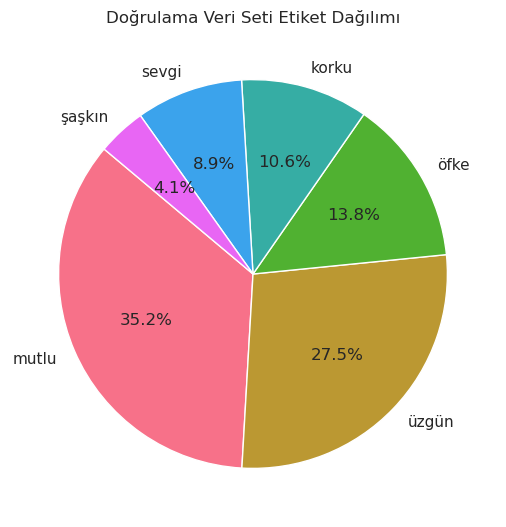

In [55]:
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts)) # renk paleti olşuturulması
sns.set(style="whitegrid") # arka plan rengi
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors) # pasta grafiği oluşturulması
plt.title('Doğrulama Veri Seti Etiket Dağılımı')
plt.show()

Eğitim veri setindeki veriler dengesiz olduğu için ve veri setini daha dengeli hale getirmeliyim.

Bunun için veri setindeki en az olan etiket sayısına sahip olan 2 etiket olan `sevgi` ve `şaşkın` etiketlerini çıkartacağım

In [56]:
train_df = train_df[~train_df['label'].str.contains('sevgi')] # sevgi etiketini çıkartılması
train_df = train_df[~train_df['label'].str.contains('şaşkın')] # şaşkın etiketini çıkartılması

Şimdi geriye kalan `mutlu`, `üzgün`, `öfke` ve `korku` etiketleri hala dengesiz bir şekilde dağılmış durumda.

Bu etikerlerin dağılımını olabildiğince birbirine yaklaştırıyorum.

In [57]:
mutlu = train_df[train_df['label'] == 'mutlu'].sample(n=2200, random_state=20) # mutlu etiketine sahip rastgele 2200 veri
uzgun = train_df[train_df['label'] == 'üzgün'].sample(n=2200, random_state=20) # üzgün etiketine sahip rastgele 2200 veri
korku = train_df[train_df['label'] == 'korku'].sample(n=1937, random_state=20)
ofke = train_df[train_df['label'] == 'öfke'].sample(n=2160, random_state=20)

new_train_df = pd.concat([mutlu, uzgun, korku, ofke]) # rastgele seçilen bu verilerin birleştirilmesi

train_df = new_train_df.sample(frac=1, random_state=20).reset_index(drop=True) # birleştirilen verileri karıştırarak train_df yi yeniden oluşturuyorum

In [58]:
train_df.label.value_counts() # etiketlerin sayısı

label
mutlu    2200
üzgün    2200
öfke     2160
korku    1937
Name: count, dtype: int64

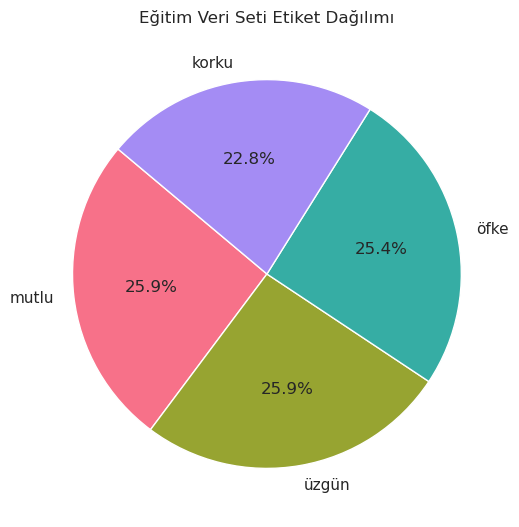

In [59]:
label_counts = train_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Eğitim Veri Seti Etiket Dağılımı')
plt.show()

Artık eğitim veri seti daha dengeli hale geldi.

Bu işlemlerin aynısını `test_df` ve `val_df` dataframeleri içinde yapacağım.

In [60]:
val_df.label.value_counts()

label
mutlu     704
üzgün     550
öfke      275
korku     212
sevgi     178
şaşkın     81
Name: count, dtype: int64

In [61]:
# sevgi ve şaşkın etiketlerinin çıkartılması
val_df = val_df[~val_df['label'].str.contains('sevgi')]
val_df = val_df[~val_df['label'].str.contains('şaşkın')]

In [62]:
mutlu = val_df[val_df['label'] == 'mutlu'].sample(n=250, random_state=20)
uzgun = val_df[val_df['label'] == 'üzgün'].sample(n=250, random_state=20)
korku = val_df[val_df['label'] == 'korku'].sample(n=212, random_state=20)
ofke = val_df[val_df['label'] == 'öfke'].sample(n=275, random_state=20)

df_sampled = pd.concat([mutlu, uzgun, korku, ofke])

val_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

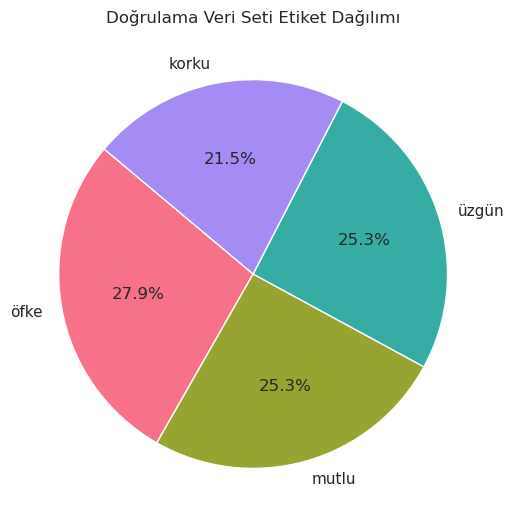

In [63]:
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Doğrulama Veri Seti Etiket Dağılımı')
plt.show()

In [64]:
test_df.label.value_counts()

label
mutlu     698
üzgün     582
öfke      274
korku     224
sevgi     155
şaşkın     67
Name: count, dtype: int64

In [65]:
# sevgi ve şaşkın etiketlerinin çıkartılması
test_df = test_df[~test_df['label'].str.contains('sevgi')]
test_df = test_df[~test_df['label'].str.contains('şaşkın')]

In [66]:
mutlu = test_df[test_df['label'] == 'mutlu'].sample(n=250, random_state=20)
uzgun = test_df[test_df['label'] == 'üzgün'].sample(n=250, random_state=20)
korku = test_df[test_df['label'] == 'korku'].sample(n=224, random_state=20)
ofke = test_df[test_df['label'] == 'öfke'].sample(n=274, random_state=20)

new_test_df = pd.concat([mutlu, uzgun, korku, ofke])

test_df = new_test_df.sample(frac=1, random_state=20).reset_index(drop=True)

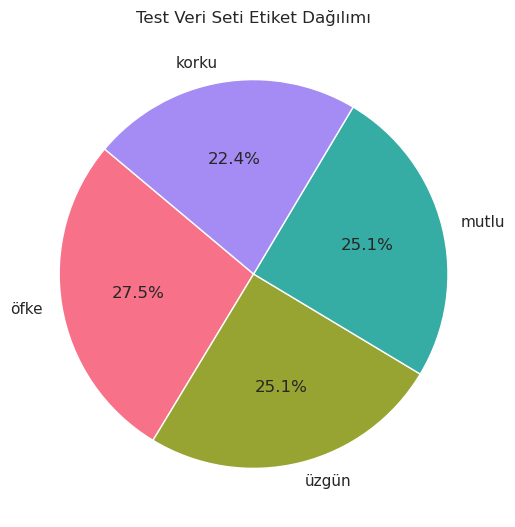

In [67]:
label_counts = test_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Test Veri Seti Etiket Dağılımı')
plt.show()

## Split Data

In [68]:
train_text = train_df['sentence']
train_label = train_df['label']

val_text = val_df['sentence']
val_label = val_df['label']

test_text = test_df['sentence']
test_label = test_df['label']

## Encoding

Şimdi bu etiketleri sayısal değerlere dönüştürüyorum

In [69]:
encoder = LabelEncoder() # etiketlerin sayısal değerlere dönüştürülmesi
tr_label = encoder.fit_transform(train_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(test_label)

## Text preprocessing

Şimdi cümleleri sayısal değerlere dönüştürerek model tarafından kullanılabilir hale getiriyorum.

In [70]:
tokenizer = Tokenizer(num_words=10000) # metinlerin sayısal değerlere dönüştürülmesi
tokenizer.fit_on_texts(train_text)

sequences = tokenizer.texts_to_sequences(train_text)
tr_x = pad_sequences(sequences, maxlen=50) # metinlerin boyutlarının eşitlenmesi
tr_y = to_categorical(tr_label, num_classes=4) # etiketlerin kategorik hale getirilmesi

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label, num_classes=4)

sequences = tokenizer.texts_to_sequences(test_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label, num_classes=4)

# Building deep learning model

Şimdi iki ayrı branch içeren ve metin sınıflandırması için kullanılabilecek bir sinir ağı tanımlıyorum.

In [71]:
max_words = 10000
max_len = 50
embedding_dim = 32

In [72]:
# Branch 1
inputs1 = layers.Input(shape=(max_len,))  # inputs1 için giriş katmanı tanımlanması

branch1 = layers.Embedding(max_words, embedding_dim)(inputs1) # Embedding katmanı
branch1 = layers.Conv1D(64, 3, padding='same', activation='relu')(branch1) # Conv1D katmanı (64 filtre, 3 kernel boyutu)
branch1 = layers.BatchNormalization()(branch1) # BatchNormalization katmanı. Katman çıktılarını normalize eder.
branch1 = layers.ReLU()(branch1) # ReLU katmanı
branch1 = layers.Dropout(0.5)(branch1) # Dropout katmanı. Aşırı uyum (overfitting) önlemek için
branch1 = layers.GlobalMaxPooling1D()(branch1) # GlobalMaxPooling1D katmanı (en büyük değeri alır)

# Branch 2
inputs2 = layers.Input(shape=(max_len,))  # inputs2 için giriş katmanı tanımlanması

branch2 = layers.Embedding(max_words, embedding_dim)(inputs2)
branch2 = layers.Conv1D(64, 3, padding='same', activation='relu')(branch2)
branch2 = layers.BatchNormalization()(branch2)
branch2 = layers.ReLU()(branch2)
branch2 = layers.Dropout(0.5)(branch2)
branch2 = layers.GlobalMaxPooling1D()(branch2)

concatenated = layers.Concatenate()([branch1, branch2]) # Branch1 ve Branch2'nin birleştirilmesi

#Birleştirilen katmanların dense katmanı tarafından gizli katmana bağlanması
hid_layer = layers.Dense(128, activation='relu')(concatenated) # Gizli katman
dropout = layers.Dropout(0.3)(hid_layer) # Dropout katmanı. Overfitting önlemek için
output_layer = layers.Dense(4, activation='softmax')(dropout) # Çıkış katmanı

# Define the model with separate inputs
model = Model(inputs=[inputs1, inputs2], outputs=output_layer)

# Compile Model

In [73]:
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 50, 32)    │    320,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 50, 32)    │    320,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 64)    │      6,208 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 50, 64)    │      6,208 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 50, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 50, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 50, 64)    │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50, 64)    │          0 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_3[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_4[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        516 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,956 (2.56 MB)

 Trainable params: 669,700 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

# Training the model

In [74]:
batch_size = 50
epochs = 10
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size, validation_data=([val_x, val_x], val_y))

Epoch 1/10


170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.2675 - loss: 1.5784 - precision_1: 0.2685 - recall_1: 0.0702 - val_accuracy: 0.2644 - val_loss: 1.3848 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3341 - loss: 1.3538 - precision_1: 0.5342 - recall_1: 0.0124 - val_accuracy: 0.3556 - val_loss: 1.3767 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3941 - loss: 1.2952 - precision_1: 0.6062 - recall_1: 0.0445 - val_accuracy: 0.4590 - val_loss: 1.3262 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5009 - loss: 1.1432 - precision_1: 0.7271 - recall_1: 0.2051 - val_accuracy: 0.5370 - val_loss: 1.1861 - val_precision_1: 0.9302 - val_recall_1: 0.0811
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5728 - loss: 1.0054 - precision_1: 0.7464 - rec

# Evaluation and Visullize results

In [75]:
(loss, accuracy, percision, recall) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9416 - loss: 0.2891 - precision_1: 0.9652 - recall_1: 0.8972
Loss: 0.3, Accuracy: 0.93, Precision: 0.96, Recall: 0.89


In [76]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6958 - loss: 0.7529 - precision_1: 0.7563 - recall_1: 0.5804 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7036 - loss: 0.7366 - precision_1: 0.7747 - recall_1: 0.5994
Loss: 0.74, Accuracy: 0.7, Precision: 0.79, Recall: 0.62


In [77]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])

## Visullize results

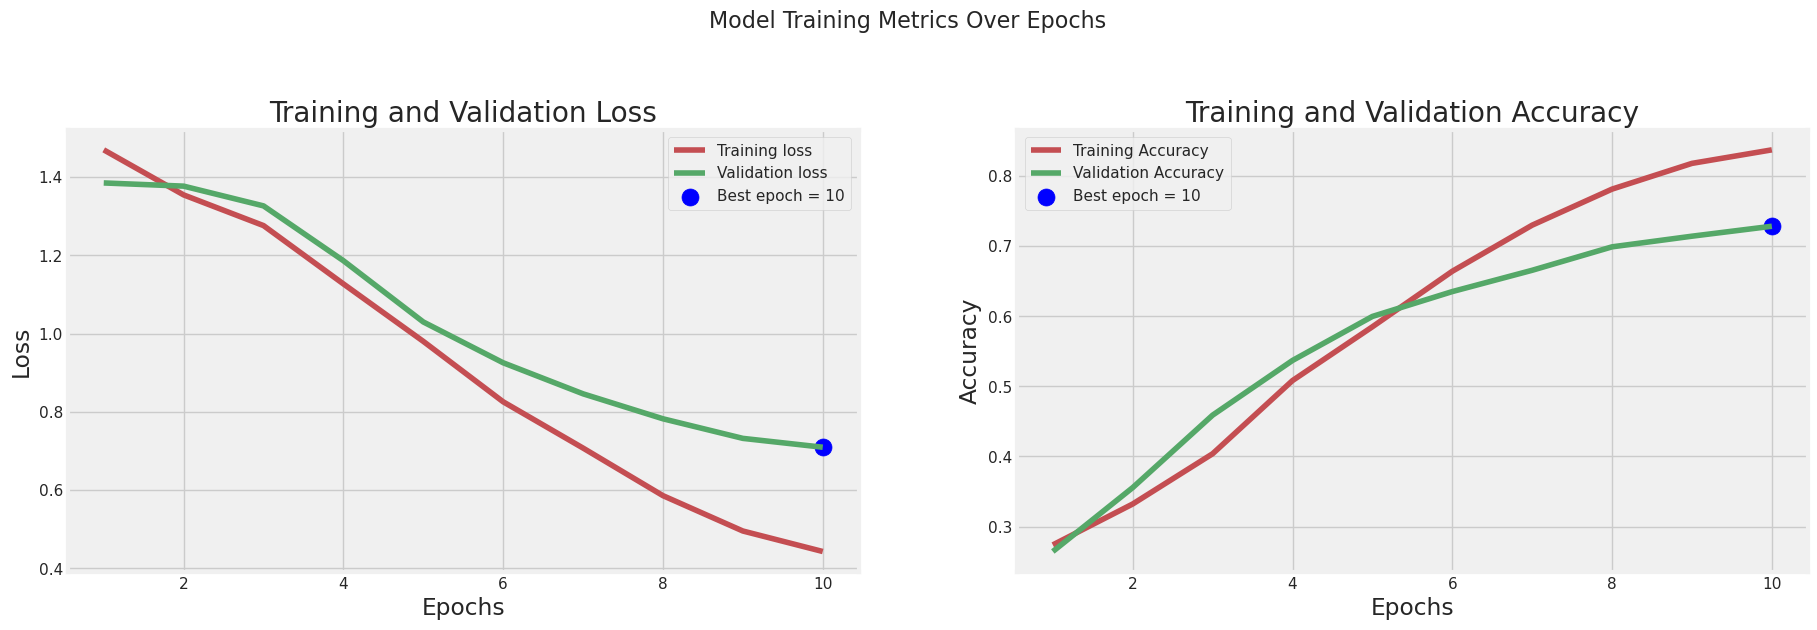

In [78]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [79]:
y_true=[] # gerçek etiketlerin tutulacağı liste
for i in range(len(ts_y)): # gerçek etiketlerin alınması
    x = np.argmax(ts_y[i]) 
    y_true.append(x)


preds = model.predict([ts_x, ts_x]) # tahminlerin alınması
y_pred = np.argmax(preds, axis=1) # tahminlerin en yüksek değerli indexlerinin alınması
y_true = np.argmax(ts_y, axis=1) # gerçek etiketlerin en yüksek değerli indexlerinin alınması
y_pred

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([2, 0, 3, 3, 1, 2, 0, 0, 2, 1, 2, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 1,
       1, 3, 0, 1, 2, 1, 3, 0, 3, 0, 3, 2, 3, 1, 3, 3, 2, 0, 0, 2, 2, 3,
       0, 0, 1, 2, 3, 0, 3, 1, 1, 1, 0, 3, 1, 1, 3, 1, 3, 3, 0, 2, 1, 3,
       2, 3, 1, 0, 2, 1, 3, 2, 2, 0, 0, 2, 1, 1, 3, 0, 3, 3, 0, 1, 2, 1,
       1, 3, 1, 1, 3, 0, 3, 0, 3, 3, 2, 1, 3, 0, 2, 0, 2, 3, 2, 1, 3, 2,
       3, 2, 3, 1, 3, 2, 3, 0, 1, 1, 3, 3, 3, 0, 3, 0, 3, 2, 1, 1, 3, 2,
       2, 3, 1, 3, 3, 2, 1, 2, 1, 3, 0, 1, 2, 2, 2, 1, 0, 0, 1, 2, 1, 1,
       2, 2, 3, 0, 2, 3, 1, 3, 0, 0, 2, 3, 2, 1, 2, 2, 1, 2, 0, 3, 1, 0,
       1, 0, 3, 1, 3, 1, 3, 0, 3, 1, 1, 1, 0, 1, 2, 2, 1, 3, 3, 3, 1, 2,
       2, 1, 0, 2, 0, 1, 1, 2, 3, 3, 2, 3, 3, 0, 0, 2, 2, 3, 3, 3, 1, 3,
       1, 3, 3, 0, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0, 3, 3, 2, 0, 1, 3, 1, 0,
       0, 1, 1, 3, 1, 2, 2, 2, 0, 3, 1, 0, 3, 2, 3, 3, 0, 3, 1, 2, 1, 2,
       3, 2, 1, 2, 2, 0, 1, 1, 3, 3, 3, 3, 1, 3, 0, 3, 2, 0, 3, 0, 1, 0,
       3, 3, 0, 0, 3, 2, 1, 0, 3, 3, 2, 1, 3, 3, 1,

<Axes: >

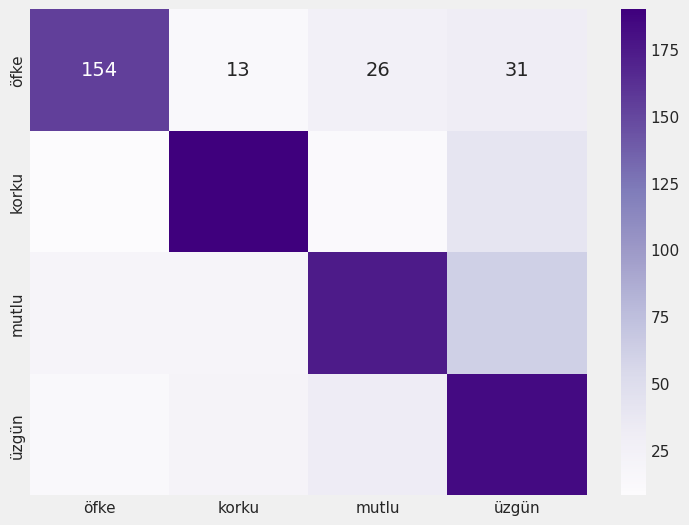

In [80]:
plt.figure(figsize=(8,6))
emotions = {0: 'öfke', 1: 'korku', 2: 'mutlu', 3:'üzgün'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred.ravel())
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=emotions, yticklabels=emotions)

In [81]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       224
           1       0.78      0.76      0.77       250
           2       0.72      0.64      0.67       274
           3       0.58      0.74      0.65       250

    accuracy                           0.70       998
   macro avg       0.72      0.70      0.71       998
weighted avg       0.72      0.70      0.71       998



# Save Model

Eğitilmiş olan tokenizatörün ve modelin kaydedilmesi

In [82]:
with open('tokenizer.pkl', 'wb') as tokenizer_file: # tokenizer nesnesinin kaydedilmesi
    pickle.dump(tokenizer, tokenizer_file)

model.save('emotions_detect_model.h5')

# Prediction Function

Tahmin fonksiyonu

In [83]:
# modülleri tekrardan import etmemin sebebi, modeli tekrar eğitmeden kaydedilen modeli kullanmak için

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [84]:
def predict(text, model_path, token_path):
    
    model = load_model(model_path)
    
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences([text]) # Tahmin edilecek metni önceden eğitilen tokenizer ile sayısal değerlere dönüştürülmesi
    x_new = pad_sequences(sequences, maxlen=50) # Metinlerin boyutlarının eşitlenmesi
    predictions = model.predict([x_new, x_new]) # Tahmin işlemi
    
    emotions = {0: 'üzgün', 1: 'mutlu', 2: 'korku', 3:'öfke'}

    # Tahmin sonuçlarının görselleştirilmesi
    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Tahmin', fontsize=15)
    plt.ylabel('Duygular', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

    return emotions[np.argmax(predictions)] # En yüksek değerli indexin alınması ve duygunun döndürülmesi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


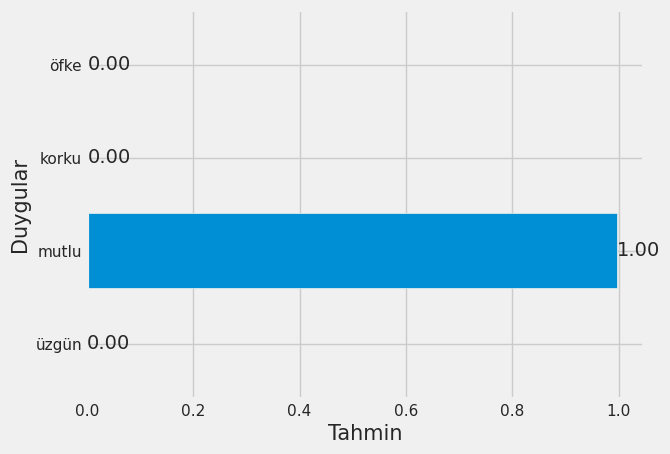

'mutlu'

In [85]:
txt = 'Projeyi bitirdiğim için kendimi harika hissediyorum'
predict(txt, 'emotions_detect_model.h5', 'tokenizer.pkl')